# Setup

## Imports

In [22]:
import pandas as pd
import numpy as np
import matplotlib
import sklearn.metrics
import seaborn as sns
from seaborn import heatmap
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from scipy import stats
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, classification_report, \
    precision_recall_curve, make_scorer, accuracy_score, average_precision_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import os
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import StratifiedKFold
import warnings

## Constants

In [23]:
numeric_columns = ['Age', 'Tscore', 'Height', 'Weight', 'BMI', 'BASP', 'PTHpmoll', 'Vitdnmoll', 'CTXmygl', 'P1NP', 'calciumion', 'creatinin', 'eGFR', 'oks_total', 'VAS_aktiv']

boolean_columns = ['Sex', 'Cem_ucem', 'TKA', 'side', 'exercise', 'former_alcoholabuse', 'smoker', 'former_smoker']

random_state = 9

# Setup Data

## Load Data

In [24]:
# Train data
train_data_path = "data/Train_data.xls"
X_train = pd.read_excel(train_data_path)
X_train.pop('Number')

# Test data
test_data_path = "data/Test_data.xls"
X_test = pd.read_excel(test_data_path)
X_test.pop('Number')

# Validation data
validation_data_path = "data/Validation_data.xls"
X_validation = pd.read_excel(validation_data_path)
number = X_validation.pop('Number')

## Preprocessing

### Fix absent data
- take mean value for mean values
- take most popular for booleans

In [25]:
# Fixes data
# When a value is missing
# - if column is numeric -> take mean
# - if column is boolean -> take most popular
def fixAbsentData(df: pd.DataFrame):

    # Get Values for numeric columns
    for column in numeric_columns:
        if column in df:
            mean = df[column].mean()
            df[column] = df[column].fillna(mean)

    # Get Values for boolean columns
    for column in boolean_columns:
        if column in df:
            mean = df[column].mean()

            if(mean <= 0.5):
                mean = 0
            else:
                mean = 1
            df[column] = df[column].fillna(mean)
    return df

train_X = fixAbsentData(X_train)
test_X = fixAbsentData(X_test)
validation_X = fixAbsentData(X_validation)

y_train = X_train.pop('MIG_group')
y_validation = X_validation.pop('MIG_group')

# Model Training

## Helper methods

In [26]:
def plot_validation_performance(clf, title: str):
    decision_function = clf.decision_function(X_validation)
    fpr, tpr, thresholds = roc_curve(y_validation, decision_function)
    y_validation_pred = clf.predict(X_validation)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6,6))
    fig.suptitle(title)

    # PLOT AUC score
    acc = clf.score(X_validation, y_validation)
    auc = roc_auc_score(y_validation, decision_function)
    clf_report = classification_report(y_validation,
                                       y_validation_pred,
                                       labels=clf.classes_,
                                       target_names=clf.classes_,
                                       output_dict=True)
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, ax=ax1)
    ax1.set_title('Scoring metrics')

    ax2.scatter(fpr, tpr, c='blue')
    ax2.plot(fpr, tpr, label="Accuracy:%.2f AUC:%.2f" % (acc, auc), linewidth=2, c='red')
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate (recall)")
    ax2.set_title('ROC Curve')
    ax2.legend(loc='best')

    # Plot confusion matrix
    cm = confusion_matrix(y_validation, y_validation_pred, labels=clf.classes_)
    df_cm = pd.DataFrame(cm, index=clf.classes_, columns=clf.classes_)
    heatmap(df_cm, cmap='Oranges', annot=True, ax=ax3)
    ax3.set_title('Confusion Matrix')

    fig.tight_layout(pad=1, w_pad=0.5, h_pad=1.0)
    return fig

def plot_cv_results(df, title):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6,6))
    fig.suptitle(title)

    results_df = df.sort_values(by=["param_clf__C"])
    results_df = results_df.set_index(
        results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
    ).rename_axis("kernel")

    # create df of model scores ordered by performance
    model_scores = results_df.filter(regex=r"split\d*_test_AUC")

    # plot 30 examples of dependency between cv fold and AUC scores
    sns.lineplot(
        data=model_scores.transpose().iloc[:30],
        dashes=False,
        palette="Set1",
        marker="o",
        alpha=0.5,
        legend='full',
        ax=ax1,
    )
    ax1.set_ylabel("Model AUC", size=12)
    ax1.tick_params(bottom=True, labelbottom=False)
    ax1.get_legend().remove()

    model_scores = results_df.filter(regex=r"split\d*_test_f1")

    # plot 30 examples of dependency between cv fold and AUC scores
    sns.lineplot(
        data=model_scores.transpose().iloc[:30],
        dashes=False,
        palette="Set1",
        marker="o",
        alpha=0.5,
        ax=ax2,
    )
    ax2.set_ylabel("Model f1", size=12)
    ax2.tick_params(bottom=True, labelbottom=False)
    ax2.get_legend().remove()

    model_scores = results_df.filter(regex=r"split\d*_test_precision")

    # plot 30 examples of dependency between cv fold and AUC scores
    sns.lineplot(
        data=model_scores.transpose().iloc[:30],
        dashes=False,
        palette="Set1",
        marker="o",
        alpha=0.5,
        ax=ax3,
    )
    ax3.set_xlabel("CV test fold", size=12, labelpad=10)
    ax3.set_ylabel("Model Precision", size=12)
    ax3.tick_params(bottom=True, labelbottom=False)
    ax3.get_legend().remove()

    hand, labl = ax3.get_legend_handles_labels()
    fig.legend(np.unique(labl), bbox_to_anchor=(1.05, 1.0), loc='upper left')
    fig.tight_layout()
    fig.show()

## SVC with default parameters

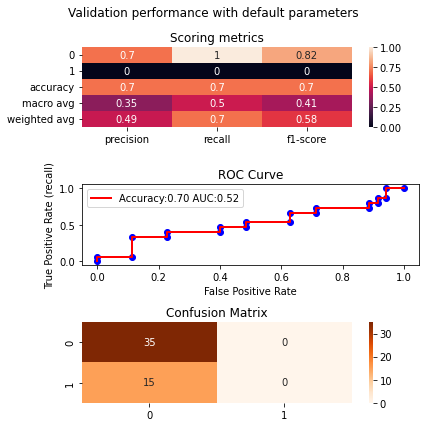

In [27]:

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    pipe = Pipeline([
        ("scaler", MinMaxScaler()),
        ("clf", SVC(random_state=random_state))
    ])

    pipe.fit(X_train, y_train)

    # Print performance on validation set
    fig = plot_validation_performance(pipe, "Validation performance with default parameters")
    fig.show()

    # Store test prediction in csv file
    predicted_test = pd.DataFrame(pipe.predict(X_test))
    predicted_test.index += 1
    predicted_test.to_csv(f"{os.getcwd()}/simple_svc.csv")

## SVC with balanced weights

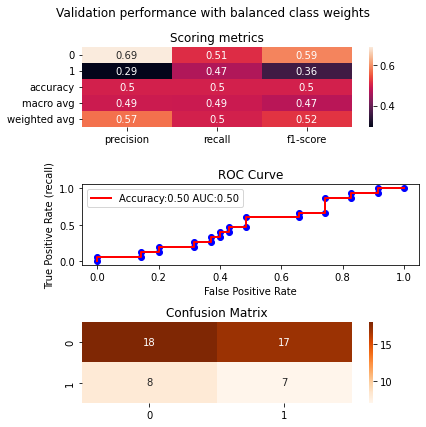

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    pipe = Pipeline([
        ("scaler", MinMaxScaler()),
        ("clf", SVC(class_weight="balanced", random_state=random_state))
    ])

    pipe.fit(X_train, y_train)

    # Print performance on validation set
    fig = plot_validation_performance(pipe, "Validation performance with balanced class weights")
    fig.show()

    # Store test prediction in csv file
    predicted_test = pd.DataFrame(pipe.predict(X_test))
    predicted_test.index += 1
    predicted_test.to_csv(f"{os.getcwd()}/simple_svc.csv")

## SVC with balanced weights - GridCV with different C's

Best Parameters                               :  {'clf__C': 100, 'scaler': MinMaxScaler()}
Best Score                                    :  0.22755022755022755


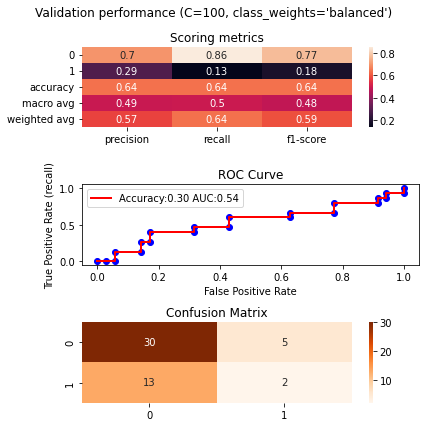

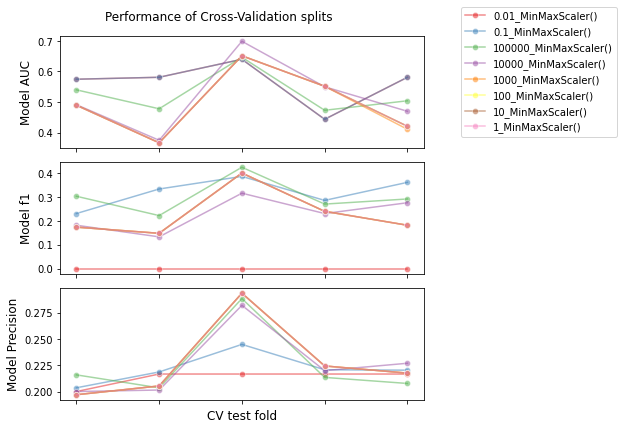

In [29]:
max_iter = 100000
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    pipe = Pipeline([
        ("scaler", MinMaxScaler()),
        ("clf", SVC(class_weight="balanced", max_iter=max_iter, random_state=random_state))
    ])

    C = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

    parameter_grid = [
        {
            "scaler": [MinMaxScaler()],
            'clf__C': C,
        },
        ]
    scoring = {"AUC": "roc_auc", "f1": "f1", "precision": make_scorer(average_precision_score)}

    grid = GridSearchCV(pipe,
                          parameter_grid,
                          n_jobs=-1,
                          cv=StratifiedKFold(n_splits=5),
                          scoring=scoring,
                          refit='precision')
    grid.fit(X_train, y_train)

    # Print performance on validation set
    fig = plot_validation_performance(grid, "Validation performance (C=100, class_weights='balanced')")
    fig.show()

    # Compare models
    print('Best Parameters                               : ',grid.best_params_)
    print('Best Score                                    : ',grid.best_score_)
    results_df = pd.DataFrame(grid.cv_results_)
    plot_cv_results(results_df, "Performance of Cross-Validation splits")

    predicted_test = pd.DataFrame(grid.predict(X_test))
    predicted_test.index += 1
    predicted_test.to_csv(f"{os.getcwd()}/test2.csv")
    results_df

## SVC with balanced weights - GridCV with different C's, SelectKBest

Best Parameters                               :  {'clf__C': 100, 'kBest__k': 21, 'scaler': MinMaxScaler()}
Best Score                                    :  0.2597384097384098


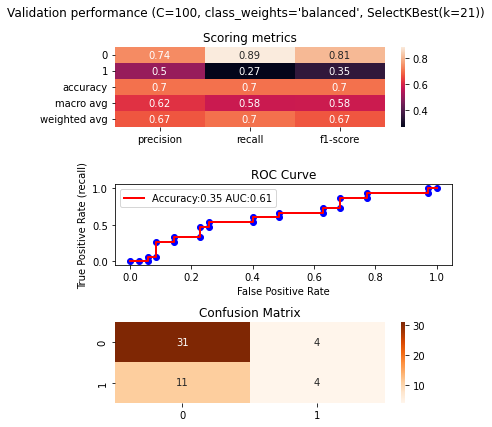

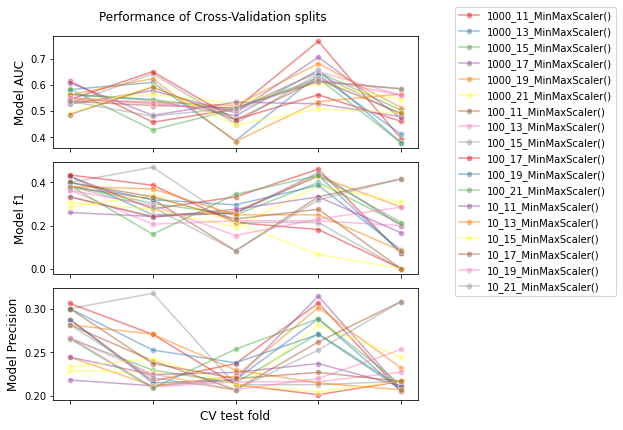

In [30]:
max_iter = 1000000
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    pipe = Pipeline([
        ("scaler", MinMaxScaler()),
        ("kBest", SelectKBest(chi2)),
        ("clf", SVC(class_weight="balanced", max_iter=max_iter, random_state=random_state))
    ])

    C = [10, 100, 1000]

    parameter_grid = [
        {
            "scaler": [MinMaxScaler()],
            'clf__C': C,
            'kBest__k': range(11, 23, 2),
        },
        ]
    scoring = {"AUC": "roc_auc", "f1": "f1", "precision": make_scorer(average_precision_score)}

    grid = GridSearchCV(pipe,
                          parameter_grid,
                          n_jobs=-1,
                          cv=StratifiedKFold(n_splits=5, random_state=random_state,
                                             shuffle=True),
                          scoring=scoring,
                          refit='precision')
    grid.fit(X_train, y_train)

    # Print performance on validation set
    fig = plot_validation_performance(grid, "Validation performance (C=100, class_weights='balanced', SelectKBest(k=21))")
    fig.show()

    # Compare models
    print('Best Parameters                               : ',grid.best_params_)
    print('Best Score                                    : ',grid.best_score_)
    results_df = pd.DataFrame(grid.cv_results_)
    plot_cv_results(results_df, "Performance of Cross-Validation splits")

    predicted_test = pd.DataFrame(grid.predict(X_test))
    predicted_test.index += 1
    predicted_test.to_csv(f"{os.getcwd()}/test2.csv")

## SVC with balanced weights - GridCV with different C's, SelectKBest, different kernels

/home/mlrosenquist/repos/au-mlr-computer-vision-and-ml/project/venv/lib64/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/mlrosenquist/repos/au-mlr-computer-vision-and-ml/project/venv/lib64/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/mlrosenquist/repos/au-mlr-computer-vision-and-ml/project/venv/lib64/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/mlrosenquist/repos/au-mlr-computer-vision-and-ml/project/venv/lib64/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max

Best Parameters                               :  {'clf__C': 100, 'clf__class_weight': 'balanced', 'clf__degree': 2, 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'kBest__k': 21, 'scaler': MinMaxScaler()}
Best Score                                    :  0.2597384097384098


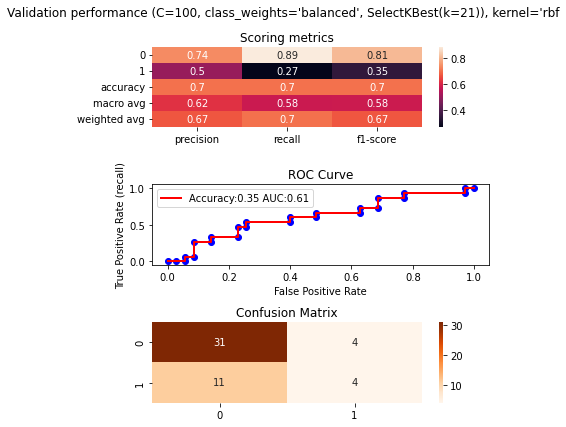

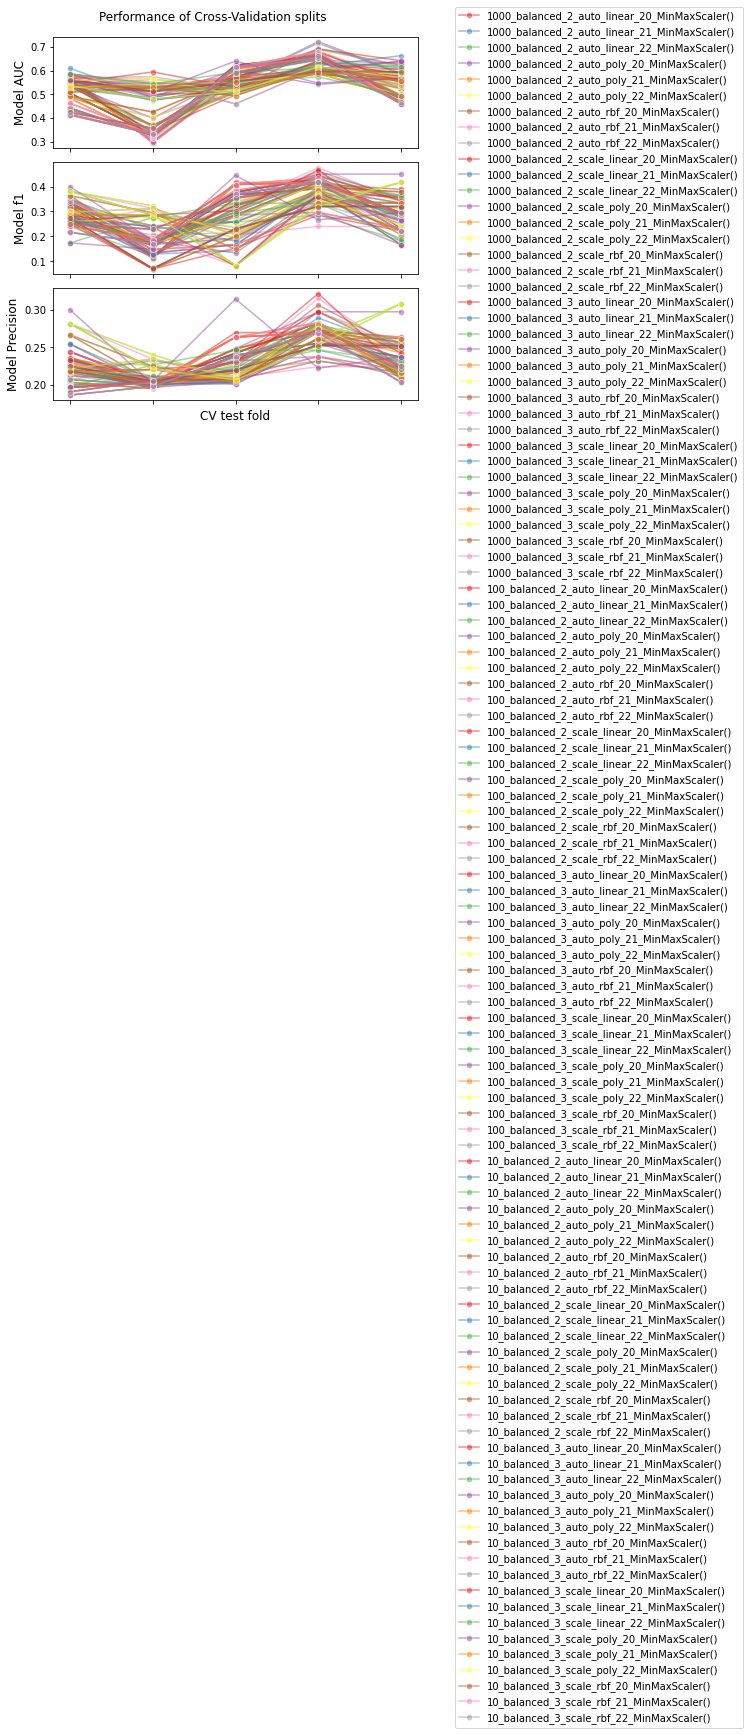

In [31]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    max_iter=100000

    pipe = Pipeline([
        ("scaler", MinMaxScaler()),
        ("kBest", SelectKBest(chi2)),
        ("clf", SVC(class_weight="balanced", max_iter=max_iter, random_state=random_state))
    ]
    )

    kernels = ['poly', 'rbf', 'linear']
    C = [10, 100, 1000]
    gamma = ['auto', 'scale']
    degree = [2, 3]
    class_weight = ['balanced']

    parameter_grid = [
        {
            "scaler": [MinMaxScaler()],
            'kBest__k': range(20,23, 1),
            'clf__kernel': kernels,
            'clf__C': C,
            'clf__gamma': gamma,
            'clf__class_weight': class_weight,
            'clf__degree': degree
        },
    ]

    scoring = {"AUC": "roc_auc", "f1": "f1", "precision": make_scorer(average_precision_score)}
    grid = GridSearchCV(pipe,
                          parameter_grid,
                          n_jobs=-1,
                          cv=StratifiedKFold(n_splits=5,
                                             random_state=random_state, shuffle=True),
                          scoring=scoring,
                          refit='precision')

    grid.fit(X_train, y_train)

    # Print performance on validation set
    fig = plot_validation_performance(grid, "Validation performance (C=100, class_weights='balanced', SelectKBest(k=21)), kernel='rbf")
    fig.show()

    # Compare models
    print('Best Parameters                               : ',grid.best_params_)
    print('Best Score                                    : ',grid.best_score_)
    results_df = pd.DataFrame(grid.cv_results_)
    plot_cv_results(results_df, "Performance of Cross-Validation splits")

    predicted_test = pd.DataFrame(grid.predict(X_test))
    predicted_test.index += 1
    predicted_test.to_csv(f"{os.getcwd()}/test2.csv")